## Making the Plots for the paper

This makes the plots for the paper.

### ASM Light curve

Let's make a fancy plot with the total ASM light curve with all observations. You know, for fun.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=2.5, rc={"axes.labelsize": 26})
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)

import numpy as np
import cPickle as pickle
#from pandas.tools.plotting import scatter_matrix
#import pandas as pd
import glob 
import astropy.io.fits as fits
import powerspectrum
#import grs1915_utils

datadir="../../"
paperdir="../documents/"


First, we're going to find all combined light curve files I made during the data preparation step and extract
the observation ID from those.

In [3]:
files = glob.glob(datadir+"*combined.dat")
print(len(files))
combined_obs = [f.split("_")[1] for f in files]

0


Next, I'll load the mission-long data file and extract the names of all ObsIDs, start, mid and stop times of observations, 
as well as the total exposure.

In [5]:
hdulist = fits.open(datadir+"GRS1915+105.fits")
h = hdulist[1]
d = h.data
all_obs = d["OBSID"]
t_start = d["T_START_OBS"]
t_mid = d["TIME"]
t_end = d["T_STOP_OBS"]
exposure = d["EXPOSURE"]

Next, I will extract start times, end times and ObsIDs where I actually have observations (rather than just monitoring, or 
weird data modes I can't use).

In [6]:
## extract start times, end times and ObsIDs from MLD where I actually have observations
mjdrefi = 49353. 
t_start_sample = np.array([s for s,o in zip(t_start, all_obs) if o in combined_obs]) + mjdrefi
t_mid_sample = np.array([s for s,o in zip(t_mid, all_obs) if o in combined_obs]) + mjdrefi
t_end_sample = np.array([s for s,o in zip(t_end, all_obs) if o in combined_obs]) + mjdrefi
exp_sample =  np.array([s for s,o in zip(exposure, all_obs) if o in combined_obs])
obs_sample = [o for o in all_obs if o in combined_obs]

Compute the total exposure time that RXTE has spent on source.


In [7]:
## exposure time by start/end times
dt = (t_end_sample - t_start_sample)*3600.*24.
## exposure times by keyword "exposure", possibly GTI corrected?
dt2 = np.sum(exp_sample)
total_time = np.sum(dt)
total_days = total_time/(3600.*24.)
print("RXTE observed GRS1915+105 for %.3f seconds, or %.3f days!"%(total_time, total_days))
print("RXTE *actually* observed GRS1915+105 (GTI-corrected?) for %.3f seconds, or %.3f days"%(dt2, dt2/(3600.*24.)))



RXTE observed GRS1915+105 for 0.000 seconds, or 0.000 days!
RXTE *actually* observed GRS1915+105 (GTI-corrected?) for 0.000 seconds, or 0.000 days


**Figure 1:** How long are all the individual observations? Let's make a histogram plot!

ValueError: x must have at least one data point

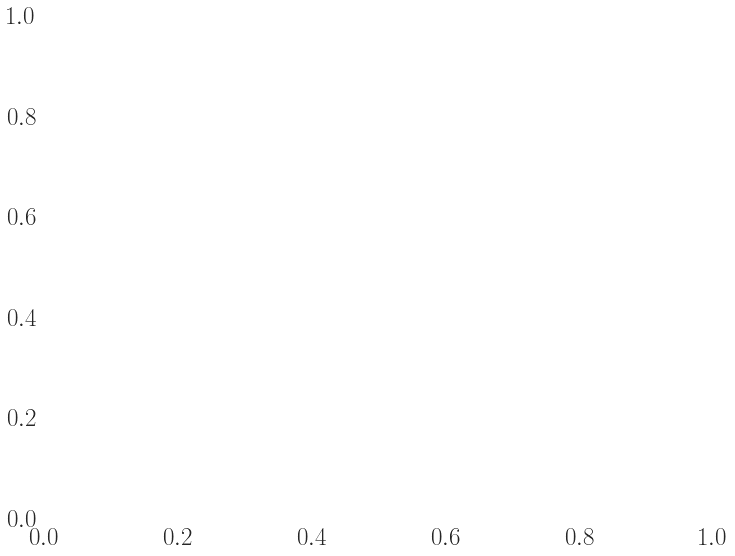

In [8]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.hist(dt, bins=30, range=[0,30000.0], histtype="stepfilled");
ax.set_xlabel("Observation length [s]", fontsize=30)
ax.set_ylabel("Number of observations", fontsize=30)
plt.savefig(paperdir+"obs_duration.pdf", format="pdf")
plt.close()

**Figure 2:** Full-page ASM light curve with the start time of the observations used marked.

In [44]:
## load and plot ASM light curve
asm = np.loadtxt(datadir+"grs1915_asm_lc.txt",skiprows=5)

asm_time = asm[:,0]
asm_cr = asm[:,1]
asm_total = asm_time[-1]-asm_time[0]
print("The ASM light curve covers a total of %i days"%asm_total)

## each light curve covers 500 days
plot_len = 500.
start_time = asm_time[0]
end_time = start_time + plot_len
i = 0

fig = plt.figure(figsize=(12,15))

sns.set_style("white")

ax = fig.add_subplot(111)
# Turn off axis lines and ticks of the big subplot

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 16})

sns.set_style("darkgrid")

plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)

plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.97, hspace=0.2)

current_palette = sns.color_palette()
while end_time <= asm_time[-1]:
    print("I am on plot %i."%i)
    ax1 = fig.add_subplot(11,1,i+1)
    ax1.errorbar(asm[:,0], asm[:,1], yerr = asm[:,2], linestyle="steps-mid")
    ax1.scatter(t_mid_sample, np.ones(len(t_mid_sample))*240., facecolor=current_palette[1],
                edgecolor="None")
    ax1.set_xlim([start_time, end_time])
    ax1.set_ylim([1.0, 299.0])
    plt.yticks(np.arange(3)*100.0+100.0, [100, 200, 300]);

    start_time +=plot_len
    end_time += plot_len
    i+=1

ax.set_xlabel("Time in MJD", fontsize=18)
ax.set_ylabel("Count rate [counts/s]", fontsize=18)

plt.savefig(paperdir+"grs1915_asm_lc_all.pdf", format="pdf")
plt.close()

The ASM light curve covers a total of 5725 days
I am on plot 0.
I am on plot 1.
I am on plot 2.
I am on plot 3.
I am on plot 4.
I am on plot 5.
I am on plot 6.
I am on plot 7.
I am on plot 8.
I am on plot 9.
I am on plot 10.


### Plotting Duration intervals versus data gaps

One thing I'd like to know is the relative length of data gaps to observation periods.
We already know the data gaps are much larger than the observations; how likely is it that a state persists over multiple observations?



In [9]:
f = open("../../grs1915_all_125ms.dat")
d_all = pickle.load(f)
f.close()

In [43]:
labels_all = np.array([d[1] for d in d_all])

for i,l in enumerate(labels_all):
    if l is None:
        labels_all[i] = "None"
    else:
        continue
        
tstart_all = np.array([d[0][0,0] for d in d_all])
tend_all = np.array([d[0][-1,0] for d in d_all])

tstart_sorted = tstart_all[tstart_all.argsort()]
tend_sorted =  tend_all[tstart_all.argsort()]
labels_sorted = labels_all[tstart_all.argsort()]

obs_times = tend_sorted - tstart_sorted
gap_times = tstart_sorted[1:] - tend_sorted[:-1]

**Figure 3**: Durations of gaps between observations

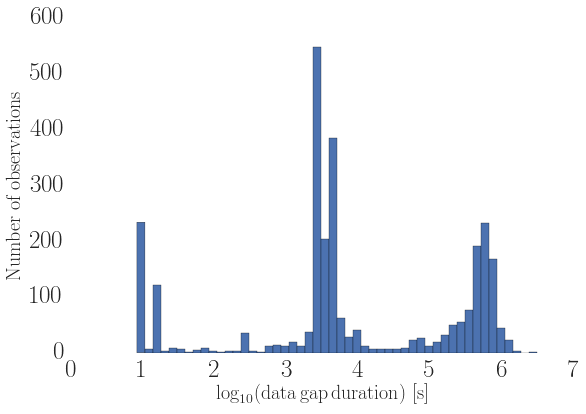

In [44]:
plt.figure(figsize=(9,6))
plt.hist(np.log10(gap_times), bins=50);
plt.xlabel(r"$\log_{10}(\mathrm{data\, gap\, duration})$ [s]")
plt.ylabel("Number of observations")
plt.savefig(paperdir+"grs1915_data_gaps.pdf", format="pdf")

At the short end: data gaps *within* observations.
Then there seem to be data gaps between 1000-10000 seconds long, comparable to the durations of the observations, and data gaps that are much longer, up to $10^6$ seconds.
For conversion:

In [45]:
import pandas as pd
seconds = np.array([10, 100, 100, 10000, 100000, 1000000, 10000000])
hours = seconds/3600.0
days = hours/24.
df = pd.DataFrame({"Seconds":seconds, "Hours":hours, "Days":days})
df

,Days,Hours,Seconds
0,0.000116,0.002778,10
1,0.001157,0.027778,100
2,0.001157,0.027778,100
3,0.115741,2.777778,10000
4,1.157407,27.777778,100000
5,11.574074,277.777778,1000000
6,115.740741,2777.777778,10000000


Question: Are the data gaps related to state?
If they are, our hidden Markov Model may be in trouble: the assumption that states are independent from observations would no longer be true!

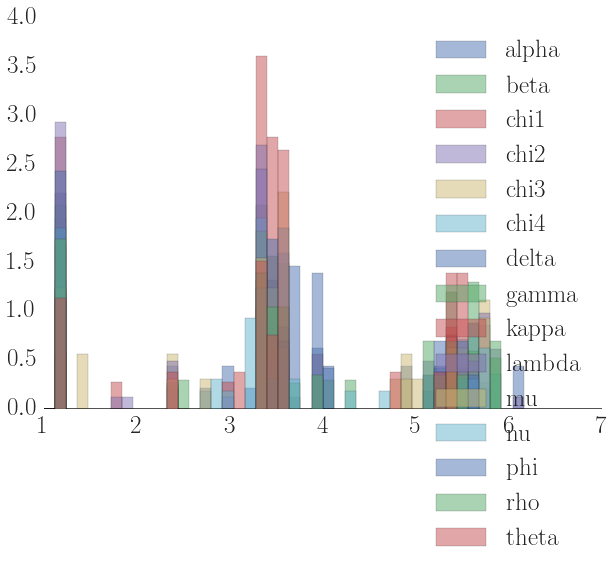

In [56]:
label_set = np.unique(labels_all)
plt.figure(figsize=(10,7))
for l in label_set[1:]:
    l_ind = np.where(labels_sorted == l)[0]
    #print(l_ind)
    gap_temp = gap_times[l_ind]
    #plt.figure(figsize=(10,7))
    plt.hist(np.log10(gap_temp), bins=50, range=[1.0, 7.0], label=l, 
             normed=True, alpha=0.5)

plt.legend()

Well, at least based on this plot, it doesn't look like there's a particular correlation between state and observation duration. This implies that our observations are probably random with respect to states.